# PRÁCTICA 1 - Laboratorio de análise intelixente de datos
### Aprendizaxe automática - Calidade de viños
##### Alumnos:
- Alexandre Lorenzo Martínez
- Lucía Pérez González
- Manuel Ramallo Blanco

Na presente práctica traballouse co dataset Wine Quality, máis concretamente co subconxunto de viños brancos contido nel. Considerouse como un problema de clasificación binaria, onde os viños con calidade $>=7$ foron considerados de alta calidade e os viños de calidade $<7$ foron considerados de baixa calidade.

## 1 - Carga e preprocesado dos datos

### 1.1 - Eliminación de duplicados
No conxunto de test, búscase eliminar as filas dupliacadas ignorando a variable `quality`, xa que dúas instancias coas mesmas características químicas pero distinta calidade considerámolas redundantes.

In [1]:
# Abrir datasets
import pandas as pd

df_vino = pd.read_csv("data/train.csv")

# Eliminación de duplicados, ignorado quality
def eliminacion_duplicados(df_vino):
    cols = df_vino.columns.drop('quality')
    df_vino = df_vino.drop_duplicates(subset=cols)
    return df_vino

### 1.2 - Binarización da calidade
Decidimos transformar a variable `quality` nunha variable binaria a que chamamos `calidad`. A asignación dos valores desta variable foron:
- 0: viños de baixa calidade
- 1: viños de alta calidade

In [2]:
def clasificar_vino(valor): 
    if valor < 7: 
        return 0
    elif valor >= 7: 
        return 1
def binarizar_calidad(df):
    df['calidad'] = df['quality'].apply(clasificar_vino) 
    df = df.drop(columns=['quality'])
    return df

### 1.3 - Xestión de valores atípicos
##### - Por unha parte empregouse o criterio de rango intercuartílico (IQR):
- Para decidir o valor do multiplicador do IQR probouse a obter a cantidade de valores marcados como atípicos con distintos valores 1.5, 3 e 6:

In [3]:
## FUNCIÓN DE EXPLICACIÓN DO PORQUÉ SE SELECCIONARON OS PARÁMETROS DECIDIDOS

# Detección de valores atípicos modificando el multiplicador del IQR
df_copia = df_vino.copy()
df_copia = eliminacion_duplicados(df_copia)
df_copia = binarizar_calidad(df_copia)

columnas = df_copia.columns.drop('calidad')
total_celdas = len(df_copia) * len(columnas)

# Inicializamos contador de atípicos por fila
df_copia["num_atipicos"] = 0

for m in [1.5, 3, 6]:
    total_atipicos = 0

    for col in columnas:
        Q1 = df_copia[col].quantile(0.25)
        Q3 = df_copia[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - m * IQR
        upper = Q3 + m * IQR

        cond= (df_copia[col] < lower) | (df_copia[col] > upper)
        total_atipicos += cond.sum()
        df_copia.loc[cond, "num_atipicos"] += 1

    porcentaje = 100 * total_atipicos / total_celdas
    distribucion_atipicos = df_copia["num_atipicos"].value_counts().sort_index()

    print(f"Multiplicador {m}: {total_atipicos} valores atípicos " f"({porcentaje:.2f}% do total)")
    print(distribucion_atipicos)
    print()


Multiplicador 1.5: 1165 valores atípicos (2.84% do total)
num_atipicos
0    2781
1     767
2     161
3      17
4       5
5       1
Name: count, dtype: int64

Multiplicador 3: 589 valores atípicos (1.43% do total)
num_atipicos
0    2781
1     364
2     448
3      81
4      46
5       9
6       1
8       2
Name: count, dtype: int64

Multiplicador 6: 401 valores atípicos (0.98% do total)
num_atipicos
0     2781
1      364
2      158
3      327
4       54
5       23
6       20
7        2
8        1
10       1
11       1
Name: count, dtype: int64



Vendo os resultados, comprobamos que o multiplicador clásico 1.5·IQR marcaba como atípico case o triplo de valores que 6·IQR. Por conseguinte, decidimos adoptar 6·IQR como o noso multiplicador xa que optamos por marcar como atípico soamente os valores realmente atípicos, e así evitar condicionar demasiados datos.

##### - Por outra parte, consideráronse tamén como atípicos os valores negativos

Xa que nesta función soamente se detectan os valores atípicos, non se decide como tratalos, éstes foron marcados como null (neste caso NA). Nesta funcón xa se traballa co conxunto de validación. Para ambos casos, tanto como no de test como no de validación, márcanse os valores atípicos como null. Cabe ser mencionado que estes null non son os únicos null presentes no dataset, senon que tamén están presentes os valores orixinalmente null.
- Desta forma, ao considerar todos os valores que se deben tratar como null, podemos manexalos conxuntamente no tratamento

In [4]:
# Deteccion de valores atipicos

def detectar_atipicos(df_train, df_val, cols_diana):
    for col in cols_diana:

        # Calculamos IQR y límites
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 6 * IQR
        upper = Q3 + 6 * IQR
        
        # Declaramos condición de atípico y registramos sus posiciones
        cond_iqr = (df_train[col] < lower) | (df_train[col] > upper)    #OLLO! Nico recomendara ver os casos 1 a 1 
        cond_neg = df_train[col] < 0
        cond_atipico = cond_iqr | cond_neg

        cond_iqr_val = (df_val[col] < lower) | (df_val[col] > upper)    #OLLO! Nico recomendara ver os casos 1 a 1 
        cond_neg_val = df_val[col] < 0
        cond_atipico_val = cond_iqr_val | cond_neg_val

        # Incrementamos el contador de atípicos por fila en ambos conjuntos
        df_train.loc[cond_atipico, col] = pd.NA
        df_val.loc[cond_atipico_val, col] = pd.NA


    return df_train, df_val

#### 1.3.1 - Tratamiento de datos atípicos

Tal e como se comentou arriba, agora que tódolos atípicos convertíronse a null, podemos tratalos conxuntamente cos valores null orixinais. 
Decidimos que o límite de valores permitidos fose 3, é dicir:
- No conxunto test, eliminaríanse as filas con 4 ou máis valores atípicos
- No resto de casos (filas con menos de 4 valores null no conxunto test, e todos os null do conxunto validación) aplicaríase unha imputación de valores empregando a mediana do conxunto test.

A decisión de tomar como cantidade límite 3 valores por fila veu dada porque a maioría das filas presentaban entre 0 e 2 valores atípicos (pódese comprobar no resultado mostrado 2 celdas máis arriba). Comprobando que a distribución de valores de atípicos se reflexaba na elección do valor `m` do IQR, decidimos que 3 era un valor adecuado.

In [5]:
def eliminar_o_imputacion(df_train, df_val, cols_diana, max_atipicos=3, umbral_col=20,  target='calidad'):
    # Eliminar filas con 4 o más valores atípicos
    # Contamos el número de valores atípicos por fila (NA) y filtramos 
    df_train = df_train[df_train.isnull().sum(axis=1) < max_atipicos]

    # Analisis de valores faltantes por columna
    for col in cols_diana:
        # Contamos el numero de valores faltantes (NA) en la columna(
        num_faltantes = df_train[col].isna().sum()
        if num_faltantes/len(df_train) > umbral_col:
            df_train = df_train.drop(columns=[col])
            df_val = df_val.drop(columns=[col])

    # Imputacion de valores: mediana para cada nulo de cada columna
    for col in cols_diana:
        med = df_train[col].median()
        df_train.loc[:, col] = df_train[col].fillna(med)
        df_val.loc[:, col] = df_val[col].fillna(med)

    return df_train, df_val


#### 1.4 - Normalización y selección de características: Reducción de dimensionalidade

Empregamos StandardScaler (estandarización) como método de normalización para adaptar os conxuntos test e de entrenamento para os modelos de predición.

In [6]:
# Normalización de los datos
from sklearn.preprocessing import StandardScaler

def estandarizar_train_test(train_df, test_df, target):
    columnas = train_df.drop(columns=[target]).select_dtypes(include="number").columns

    scaler = StandardScaler()


    train_df[columnas] = scaler.fit_transform(train_df[columnas])
    test_df[columnas] = scaler.transform(test_df[columnas])

    return train_df, test_df


En canto a selección de características aplicamos SelectKBest con f_regression.

In [7]:
# Selección de características con SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression

def seleccion_caracteristicas(df, k, target='calidad'):
    X = df.drop(columns=[target])
    y = df[target]

    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)

    selected_features = X.columns[selector.get_support()]

    df_fs = df[selected_features.tolist() + [target]]
    return df_fs


#### 1.5 - Función que empaqueta o preprocesado

A seguinte función é a que recolle as anteriores funcións de preprocesado definidas:

In [8]:
def preprocesado(train_df_pre, valid_df_pre, target='calidad'):
    df_train = train_df_pre.copy()
    df_val = valid_df_pre.copy()
    cols_diana = [c for c in train_df_pre.columns if c not in [target]]


    # Detección de atípicos en train y valid
    df_train, df_val = detectar_atipicos(df_train, df_val, cols_diana)

    # Tratamiento de atípicos: eliminación o imputación
    df_train, df_val = eliminar_o_imputacion(df_train, df_val, cols_diana)

    # Normalización de los datos
    df_train, df_val = estandarizar_train_test(df_train, df_val, target)

    # Selección de características con SelectKBest
    df_train = seleccion_caracteristicas(df_train, k=10, target=target)
    df_val = df_val[df_train.columns]
    return df_train, df_val 


## 2 - Entrenamento do modelo de predicción

Tal e como pide o enunciado da práctica, implementáronse 4 modelos de predición. Non soamente creamos, axustamos e validamos os modelos, senon que definimos unha serie de hiperparámetros para cada modelo para axustalos na validación cruzada.

- A seguinte función é a función que nos permite aforrar tempo en caso de repetición do experimento cos mesmos datos: nunha primeira execución gárdase en disco o modelo executado, en caso de xa existir un ficheiro co mesmo nome, é dicir, se xa existe gardado en disco, afórrase o tempo de execución e cálculo e cárganse diretamente os datos modelo gardado no disco.

In [9]:
import pickle
import os

def entrenar_o_cargar(modelo, X_train, y_train, nombre_modelo_archivo):
    #Cargar el modelo si existe
    if os.path.exists(nombre_modelo_archivo):
        with open(nombre_modelo_archivo, "rb") as f:
            modelo = pickle.load(f)
    #Si no existe, entrenar el modelo y guardarlo
    else:
        modelo.fit(X_train, y_train)
        with open(nombre_modelo_archivo, "wb") as f:
            pickle.dump(modelo, f)
    
    return modelo

A continuación, definimos as distintas combinación de hiperparámetros para cada modelo:
##### - kNN
Axustouse o parámetro `n_neighbors` para 3, 5, 7 e 9

##### - Árbores de decisión
Axustáronse:
- `max_depth` para 5 e 10
- `min_samples_split` para 2 e 10
- `min_samples_leaf` para 1 e 5
Estes parámetros controlan a complexidade da árbore e evitan sobreaxuste

##### - Regresión loxística
Axustáronse:
- `C` para 0.1, 1 e 10
- `penalty`  constante en elasticnet
- `l1_ratio` para 0 e 1
O parámetro `C` controla a regularización.
Por outra parte, mantendo `penalty` constante en elasricnet pero cambiando `l1_ratio` entre 0 e 1 permite traballar con penalización L1 e L2

##### - Perceptrón multicapa
Axustáronse:
- `hidden_layer_sizes` para (50,) (1 capa oculta de 50 neuronas), (100,) (1 capa oculta de 100 neuronas) e (50, 50) (2 capas ocultas de 50 neuronas cada unha)
- `learning_rate` para 0.001 e 0.01
Cabe ser mencionado que se empregou `solver`='lbfgs' para mellorar a converxencia.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

model_configs = [

    # ======================
    # kNN
    # ======================
    #0
    {"name": "knn", "model": KNeighborsClassifier, "params": {"n_neighbors": 3}},
    #1
    {"name": "knn", "model": KNeighborsClassifier, "params": {"n_neighbors": 5}},
    #2
    {"name": "knn", "model": KNeighborsClassifier, "params": {"n_neighbors": 7}},
    #3
    {"name": "knn", "model": KNeighborsClassifier, "params": {"n_neighbors": 9}},

    # ======================
    # Árbol de Decisión
    # ======================
    #4
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 5, "min_samples_split": 2, "min_samples_leaf": 1}},
    #5
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 5, "min_samples_split": 2, "min_samples_leaf": 5}},
    #6
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 5, "min_samples_split": 10, "min_samples_leaf": 1}},
    #7
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 5, "min_samples_split": 10, "min_samples_leaf": 5}},
    #8
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 1}},
    #9
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 10, "min_samples_split": 2, "min_samples_leaf": 5}},
    #10
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 1}},
    #11
    {"name": "decision_tree", "model": DecisionTreeClassifier,
    "params": {"max_depth": 10, "min_samples_split": 10, "min_samples_leaf": 5}},

    # ======================
    # Regresión Logística
    # ======================
    #12
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 1, "penalty": "elasticnet", "C": 0.1, "solver": "saga", "random_state": 0}},
    #13
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 1, "penalty": "elasticnet", "C": 1.0, "solver": "saga", "random_state": 0}},
    #14
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 1, "penalty": "elasticnet", "C": 10.0, "solver": "saga", "random_state": 0}},
    #15
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 0, "penalty": "elasticnet", "C": 0.1, "solver": "saga", "random_state": 0}},
    #16
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 0, "penalty": "elasticnet", "C": 1.0, "solver": "saga", "random_state": 0}},
    #17
    {"name": "RegrsionLoxistica", "model": LogisticRegression, "params": {"l1_ratio": 0, "penalty": "elasticnet", "C": 10.0,"solver": "saga","random_state": 0}},
        
    # ======================
    # Perceptrón multicapa
    # ======================
    #18
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (50,), 
                                                                       "learning_rate_init": 0.001, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}},
    
    #19
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (50,), 
                                                                       "learning_rate_init": 0.01, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}},
    #20
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (100,), 
                                                                       "learning_rate_init": 0.001, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}},
    #21
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (100,), 
                                                                       "learning_rate_init": 0.01, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}},   
    #22
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (50, 50), 
                                                                       "learning_rate_init": 0.001, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}},
    #23
    {"name": "PerceptronMulticapa", "model": MLPClassifier, "params": {"hidden_layer_sizes": (50, 50), 
                                                                       "learning_rate_init": 0.01, "max_iter": 1500, "random_state": 0, "solver": "lbfgs"}}
]

Na seguinte función recollemos a validación cruzada anidada. Nela dividiremos o conxunto en 6 particións, sobre as que realizaremos:
- Una validación exterior consistente en 3 iteracións, no que un grupo de 2 particións actuará como conxunto de test externo e as demáis como conxunto de adestramento externo
- En cada unha desas iteracións, realizarase unha validación cruzada interna sobre as 4 particións de adestramento externas.
- Esta validación interna farase tantas veces como combinacións de hiperparámetros se definisen, ata obter a combinación cun maior rendemento.
- Empregando a combinación de hiperparámetros óptima, adestrarase o modelo no conxunto de adestramento externo e validarase no conxunto de proba externo.

### PROCESO:
1. Comezamos realizando un preprocesado inicial sobre o dataset obxectivo, eliminando duplicados e convertíndoo nunha clasificación binaria. A continuación mezclamos o dataset para unha maior aleatoriedade.

2. Procédese a dividilos datos nas 6 particións que se empregarán para a validacióm cruazda.

3. Dentro de cada iteración externa:
- 3.1. Constrúese un diccionario para cada iteración externa: almacénase nun array de puntuación para cada modelo evaluado na validación cruzada interna. Conterá:
    - Nome
    - Modelo
    - Parámetros: Combinación de hiperparámetros empregada
    - Accuracy: Porcentaxe total de acertos na predición
    - Precision: Porcentaxe de predicións positivas realmente positivas
    - Recall: Porcentaxe dos positivos predecidos correctamente
    - F1: Medida que representa o equilibrio entre a precisión e o recall
O que teña mellor media será o usado para adestrar co conxunto completo na iteración externa e evaliar na súa validación externa.

- 3.2. Repartimos as 2 particións de validación e as 4 de adestramento. 

- 3.3. Dentro de cada iteración interna:
    - Preprocesamos os conxuntos e separamos características e etiquetas para adestramento e validación.
    - Para partición efectúase un bucle que recorre as distintas combinacións de hiperparámetros definidas para todos os modelos
        - Entrénase o modelo con cada combinación e avalíase en validación interna

- 3.4. Ao finalizala validación interna, calcúlase a media dos resultados

4. Finalizadas as iteracións externas, eliminamos duplicados de presentes nos mellores resultados obtidos na validación interna para que non haia configuracións repetidas na avaliación externa

5. A continuación evalúanse os modelos escollidos entrenándoos e validándoos contra os tres conxuntos exteriores.

6. Ao finalizar as iteracións calcúlanse as medias para as métricas producidas e obtense o rendemento final de cada configuración.

7. Por último, fíltranse as mellores configuracións para cada modelo seguindo as medias anteriores e devólvense.

In [11]:
# Modelo de entrenamiento
import numpy as np
import pandas as pd
from itertools import groupby
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def nested_cv(df, target='calidad'):
    """
    Validación cruzada anidada:
    - exterior: 3 iteraciones (6 pedazos, 4 train, 2 val)
    - interior: 4 pedazos (3 train, 1 val)
    
    Devuelve: diccionario con información de folds
    """
    #preprocesado inicial
    df = eliminacion_duplicados(df)
    df = binarizar_calidad(df)
    # Mezclar el dataset para aleatoriedad
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    n = len(df_shuffled)
    
    # Dividir en 6 pedazos iguales (outer)
    outer_splits = [ df_shuffled.iloc[i::6] for i in range(6) ]
    
    results = []
    best_models_inner = []
    # Outer CV
    for outer_iter in range(3):
        #Se construye el diccionario para cada iteración externa -> se almacena un array de puntuaciones para cada modelo evaluado en la VC interna
        #El que tenga mejor media será el usado para entrenar con el conjunto completo del fold externo y evaluar en su validación externa
        inner_models = []
        # Inicializar estructura para acumular scores
        for config in model_configs:
            inner_models.append({
                "name": config["name"],
                "model": config["model"],
                "params": config["params"],
                "acc": [],
                "prec": [],
                "rec": [],
                "f1": []
            })
        # Elegimos 4 pedazos para train, 2 para val
        outer_train_idx = [(outer_iter + i) % 6 for i in range(4)]
        outer_valid_idx = [(outer_iter + 4 + i) % 6 for i in range(2)]
        
        train_outer = pd.concat([outer_splits[i] for i in outer_train_idx])
        valid_outer = pd.concat([outer_splits[i] for i in outer_valid_idx])
        
        # Dividir train_outer en 4 pedazos para inner CV
        train_shuffled = train_outer.sample(frac=1, random_state=outer_iter).reset_index(drop=True)
        indices_inner = np.array_split(train_shuffled.index, 4)
        inner_splits = [train_shuffled.loc[idx] for idx in indices_inner]

        
        # Inner CV
        for inner_iter in range(4):
            inner_valid_pre = inner_splits[inner_iter]
            inner_train_pre = pd.concat([s for j, s in enumerate(inner_splits) if j != inner_iter])
            
            # Preprocesar
            df_train, df_val = preprocesado(inner_train_pre, inner_valid_pre, target)
            #Se separan características y etiquetas para entrenamiento y validación
            X_train = df_train.drop(columns=[target])
            y_train = df_train[target]
            X_val = df_val.drop(columns=[target])
            y_val = df_val[target]


            # Bucle que recorre los modelos con sus configuraciones guardadas en model_configs
            for i, config in enumerate(model_configs):
                # Inicializar el modelo con los parámetros de la configuración
                modelo = config["model"](**config["params"])
                
                # Entrenar el modelo y evaluar en validación interna
                modelo = entrenar_o_cargar(modelo, X_train, y_train, f"results/modelo_{config['name']}_outer{outer_iter}_inner{inner_iter}_params{tuple(config['params'].values())}.pkl")
                preds = modelo.predict(X_val)
                acc = accuracy_score(y_val, preds)
                prec = precision_score(y_val, preds)
                rec = recall_score(y_val, preds)
                f1 = f1_score(y_val, preds)
                
                # Guardar las puntuaciones obtenidas para esta configuración
                inner_models[i]["acc"].append(acc)
                inner_models[i]["prec"].append(prec)
                inner_models[i]["rec"].append(rec)
                inner_models[i]["f1"].append(f1)

        for model in inner_models:
            model["mean_acc"] = np.mean(model["acc"])
            model["mean_prec"] = np.mean(model["prec"])
            model["mean_rec"] = np.mean(model["rec"])
            model["mean_f1"] = np.mean(model["f1"])

        inner_models_sorted = sorted(inner_models, key=lambda x: x["name"])

        

        for name, group in groupby(inner_models_sorted, key=lambda x: x["name"]):
            group_list = list(group)
            best_model = max(group_list, key=lambda x: x["mean_f1"])
            best_models_inner.append(best_model)
            
    #Eliminar duplicados de best_models_inner para que no haya configuraciones repetidas en la evaluación externa
    seen_configs = set()
    unique_best_models = []
    for model in best_models_inner:
        config_key = tuple(sorted(model["params"].items()))
        if config_key not in seen_configs:
            seen_configs.add(config_key)
            unique_best_models.append(model)
    best_models_inner = unique_best_models

    #Guardar en el array de results las configuraciones de los mejores modelos de la VC interna para luego entrenarlos con el fold completo del outer train y evaluarlos en el outer val
    for model in best_models_inner:
            results.append({
                "name": model["name"],
                "model": model["model"],
                "params": model["params"],
                "acc": [],
                "prec": [],
                "rec": [],
                "f1": []
            })
        
    for outer_iter in range(3):
        # Elegimos 4 pedazos para train, 2 para val
        outer_train_idx = [(outer_iter + i) % 6 for i in range(4)]
        outer_valid_idx = [(outer_iter + 4 + i) % 6 for i in range(2)]
        
        train_outer = pd.concat([outer_splits[i] for i in outer_train_idx])
        valid_outer = pd.concat([outer_splits[i] for i in outer_valid_idx])
        
        # Preprocesar outer validation usando train outer
        train_outer_proc, valid_outer_proc = preprocesado(train_outer, valid_outer, target)
        X_train_outer = train_outer_proc.drop(columns=[target])
        y_train_outer = train_outer_proc[target]
        X_valid_outer = valid_outer_proc.drop(columns=[target])
        y_valid_outer = valid_outer_proc[target]
        # Entrenar los mejores modelos con los datos del outer train
        

        for i, best_model in enumerate(best_models_inner):
            #print(f"Outer Iteration {outer_iter}, Evaluating model {best_model['name']} with params {best_model['params']}")
            modelo_outer = best_model["model"](**best_model["params"])
            modelo_outer = entrenar_o_cargar(modelo_outer, X_train_outer, y_train_outer, f"results/modelo_{best_model['name']}_outer{outer_iter}_params{tuple(best_model['params'].values())}.pkl")
            preds = modelo_outer.predict(X_valid_outer)
            acc = accuracy_score(y_valid_outer, preds)
            prec = precision_score(y_valid_outer, preds)
            rec = recall_score(y_valid_outer, preds)
            f1 = f1_score(y_valid_outer, preds)

            #Guardar las puntuaciones obtenidas para esta configuración en cada evaluación externa
            results[i]["acc"].append(acc)
            results[i]["prec"].append(prec)
            results[i]["rec"].append(rec)
            results[i]["f1"].append(f1)

    #Cálculo de la media de las métricas para cada modelo en las evaluaciones externas
    for model in results:
        model["mean_acc"] = np.mean(model["acc"])
        model["mean_prec"] = np.mean(model["prec"])
        model["mean_rec"] = np.mean(model["rec"])
        model["mean_f1"] = np.mean(model["f1"])

    best_overall_models = []
    # Escoger las mejores configuraciones de cada modelo según la métrica F1 en la validación externa
    for name, group in groupby(sorted(results, key=lambda x: x["name"]), key=lambda x: x["name"]):
        group_list = list(group)
        best_model = max(group_list, key=lambda x: x["mean_f1"])
        best_overall_models.append(best_model)
    return best_overall_models


In [12]:
mejores_modelos = nested_cv(pd.read_csv("data/train.csv"), target='calidad')

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.5.2. This might lead to

In [13]:
mejores_modelos

[{'name': 'PerceptronMulticapa',
  'model': sklearn.neural_network._multilayer_perceptron.MLPClassifier,
  'params': {'hidden_layer_sizes': (50, 50),
   'learning_rate_init': 0.001,
   'max_iter': 1500,
   'random_state': 0,
   'solver': 'lbfgs'},
  'acc': [0.7628617363344051, 0.7773311897106109, 0.7853697749196141],
  'prec': [np.float64(0.458041958041958),
   np.float64(0.5230263157894737),
   np.float64(0.5250836120401338)],
  'rec': [np.float64(0.4833948339483395),
   np.float64(0.5463917525773195),
   np.float64(0.5567375886524822)],
  'f1': [np.float64(0.4703770197486535),
   np.float64(0.534453781512605),
   np.float64(0.540447504302926)],
  'mean_acc': np.float64(0.77518756698821),
  'mean_prec': np.float64(0.5020506286238552),
  'mean_rec': np.float64(0.528841391726047),
  'mean_f1': np.float64(0.5150927685213949)},
 {'name': 'RegrsionLoxistica',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'params': {'l1_ratio': 1,
   'penalty': 'elasticnet',
   'C': 10.0,


#### Resultados obtidos na validación cruzada
Como resultado do entrenamiento obtívose a mellor configuración dos catro modelos probados e explicados anteriormente. Aínda que se recollesen as métricas de `accuracy`, `recall`, `precision` e `f1`, a medida que se usou para facer a distinción e decidirse por unha configuración concreta é a de F1. Esto é así porque se trata dunha clasificación binaria desbalanceada e esta medida é moi representativa neste tipo de problemas. Os modelos obtidos foron os seguintes:
- Knn con parámetro `n_neighbors`: 3
- Regresión loxística con parámetros `l1_ratio`: 1, `penalty`: elasticnet, `C`: 10.0
- Árbore de decisión con parámetros `max_depth`: 10, `min_samples_split`: 2, `min_samples_leaf`: 1
- Perceptrón multicapa con parámetros `hidden_layer_sizes`: (50, 50), `learning_rate_init`: 0.001

In [14]:
def ejecucion_prediccion(file_train, file_test, configuracion_modelo):
    df_train = pd.read_csv(file_train)
    df_test = pd.read_csv(file_test)
    
    # preprocesado inicial
    df_train = eliminacion_duplicados(df_train)
    df_train = binarizar_calidad(df_train)
    df_test = eliminacion_duplicados(df_test)
    df_test = binarizar_calidad(df_test)
    
    # Preprocesar
    df_train_proc, df_test_proc = preprocesado(df_train, df_test, target='calidad')
    # Separar características y etiquetas
    X_train = df_train_proc.drop(columns=['calidad'])
    y_train = df_train_proc['calidad']
    X_test = df_test_proc.drop(columns=['calidad'])
    y_test = df_test_proc['calidad']

    # Entrenar el modelo con la configuración dada
    modelo = configuracion_modelo["model"](**configuracion_modelo["params"])
    modelo = entrenar_o_cargar(modelo, X_train, y_train, f"results/modelo_final_{configuracion_modelo['name']}_params{tuple(configuracion_modelo['params'].values())}.pkl")

    # Hacer predicciones
    y_pred = modelo.predict(X_test)
    # Calcular métricas
    resultados = []
    resultados.append({"accuracy": accuracy_score(y_test, y_pred)})
    resultados.append({"precision": precision_score(y_test, y_pred)})
    resultados.append({"recall": recall_score(y_test, y_pred)})
    resultados.append({"f1_score": f1_score(y_test, y_pred)})
    return resultados

In [15]:
resPerceptron = ejecucion_prediccion("data/train.csv", "data/test_2.csv", model_configs[22])
resPerceptron

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[{'accuracy': 0.8350951374207188},
 {'precision': np.float64(0.5865384615384616)},
 {'recall': np.float64(0.6354166666666666)},
 {'f1_score': np.float64(0.61)}]

In [16]:
resRegresionLoxistica = ejecucion_prediccion("data/train.csv", "data/test_2.csv", model_configs[14])
resRegresionLoxistica

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[{'accuracy': 0.8202959830866807},
 {'precision': np.float64(0.6774193548387096)},
 {'recall': np.float64(0.21875)},
 {'f1_score': np.float64(0.33070866141732286)}]

In [17]:
resArbore = ejecucion_prediccion("data/train.csv", "data/test_2.csv", model_configs[8])
resArbore

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[{'accuracy': 0.8054968287526427},
 {'precision': np.float64(0.52)},
 {'recall': np.float64(0.5416666666666666)},
 {'f1_score': np.float64(0.5306122448979592)}]

In [18]:
resKnn = ejecucion_prediccion("data/train.csv", "data/test_2.csv", model_configs[0])
resKnn

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.6.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[{'accuracy': 0.8160676532769556},
 {'precision': np.float64(0.5463917525773195)},
 {'recall': np.float64(0.5520833333333334)},
 {'f1_score': np.float64(0.5492227979274611)}]

#### Visualización dos resultados

In [19]:
import matplotlib.pyplot as plt

# Nombres de modelos
model_names = ["Regresión Logística", "Perceptrón", "Árbol de Decisión", "KNN"]

# Extraer valores
accuracy_values = [
    resRegresionLoxistica[0]["accuracy"],
    resPerceptron[0]["accuracy"],
    resArbore[0]["accuracy"],
    resKnn[0]["accuracy"],
]

precision_values = [
    resRegresionLoxistica[1]["precision"],
    resPerceptron[1]["precision"],
    resArbore[1]["precision"],
    resKnn[1]["precision"],
]

recall_values = [
    resRegresionLoxistica[2]["recall"],
    resPerceptron[2]["recall"],
    resArbore[2]["recall"],
    resKnn[2]["recall"],
]

f1_values = [
    resRegresionLoxistica[3]["f1_score"],
    resPerceptron[3]["f1_score"],
    resArbore[3]["f1_score"],
    resKnn[3]["f1_score"],
]

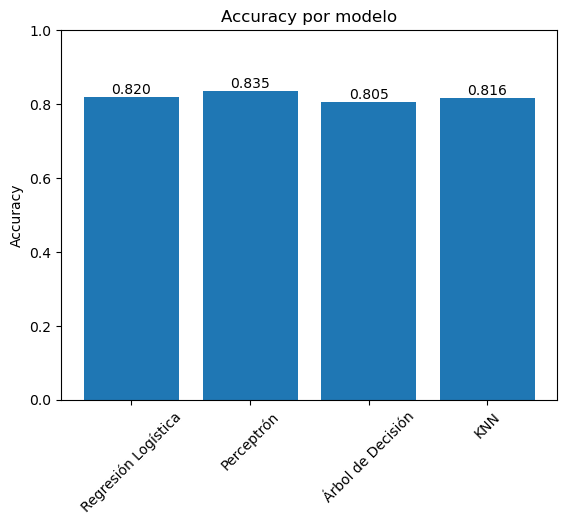

In [20]:
# Accuracy
plt.figure()
bars = plt.bar(model_names, accuracy_values)
plt.title("Accuracy por modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",     # 3 decimales
        ha='center',
        va='bottom'
    )
plt.show()

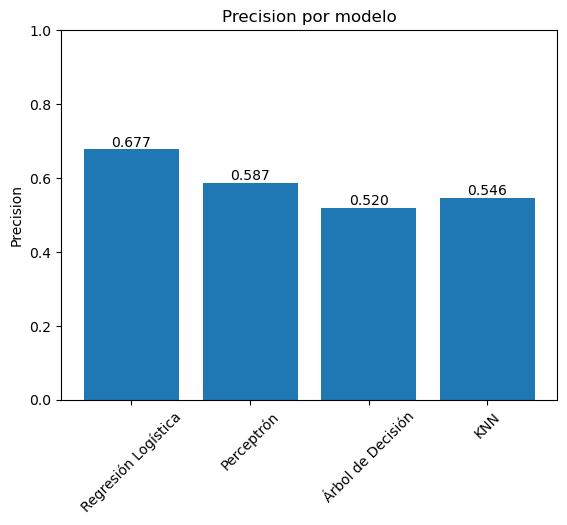

In [21]:
# Precision
plt.figure()
bars = plt.bar(model_names, precision_values)
plt.title("Precision por modelo")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",     # 3 decimales
        ha='center',
        va='bottom'
    )
plt.show()

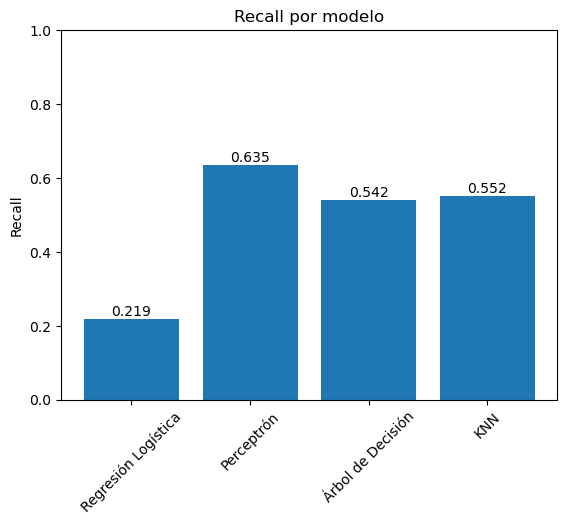

In [22]:
# Recall
plt.figure()
bars = plt.bar(model_names, recall_values)
plt.title("Recall por modelo")
plt.ylabel("Recall")
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",     # 3 decimales
        ha='center',
        va='bottom'
    )
plt.show()

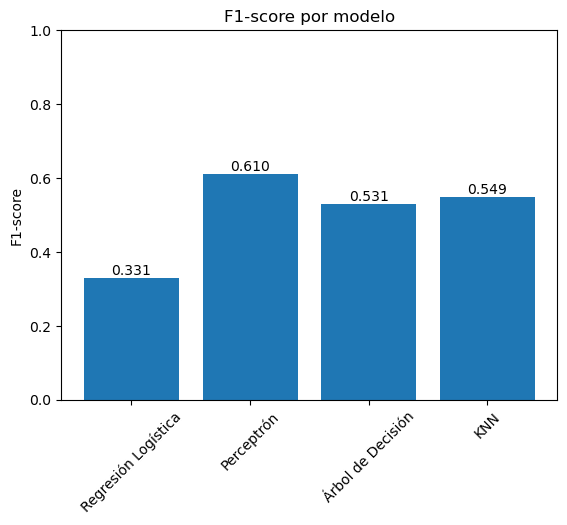

In [23]:
# F1-score
plt.figure()
bars = plt.bar(model_names, f1_values)
plt.title("F1-score por modelo")
plt.ylabel("F1-score")
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.3f}",     # 3 decimales
        ha='center',
        va='bottom'
    )
plt.show()

Facendo unha comparativa sobre as diferentes estratexias, pódese observar que o valor do `accuracy` é moi similar para os catro modelos. Isto é normal porque o desbalanceo de clases é considerable e os marxes de erro nesta métrica redúcense. Sen embargo, no resto de medidas hai diferenzas maiores. A regresión loxística é a que mellor rendemento obtivo en canto a `precision`, pero o valor de `recall` é moi pobre, e polo tanto tamén o da medida `F1`. Por outra parte, o modelo máis equilibrado é o perceptrón multicapa, sendo o óptimo no `recall` e na medida `F1`, polo que se pode concluir que nesta instancia de problema é o que mellor se adapta e se comporta.